### Import packages and functions

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import seaborn as sns
import scipy.stats
import anndata
import os
import scipy as scipy
import scipy as sp
import pickle as pkl
import matplotlib.pyplot as plt
import re
from collections import defaultdict
from statsmodels.nonparametric.smoothers_lowess import lowess
from numpy import asarray as ar
from collections import Counter
import networkx as nx
import igraph
import glob

os.getcwd()

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=100, color_map='Blues')
sc.logging.print_version_and_date()
sc.logging.print_header()

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-95xuht7n because the default path (/home/ubuntu/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Running Scanpy 1.6.0, on 2022-03-02 16:43.
scanpy==1.6.0 anndata==0.7.5 umap==0.4.6 numpy==1.19.5 scipy==1.5.4 pandas==1.1.5 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.8 louvain==0.7.0


In [2]:
def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3 

def subtraction(lst1, lst2): 
    lst3 = [value for value in lst1 if not value in lst2] 
    return lst3

### Importing metadata

In [3]:
meta = pd.read_csv('/mnt/Science_revision/meta_PIP.csv', index_col='Sanger Sample ID')

In [4]:
meta.head(1)

Source ID sex patient no organ code       sample ID
Sanger Sample ID                                                    
Pan_T7935490          390C   F        A29        ILE  A29-ILE-0-SC-1

In [5]:
meta.shape

(61, 5)

In [6]:
samples = list(meta.index)

In [7]:
list(meta.index)

['Pan_T7935490',
 'Pan_T7935492',
 'Pan_T7935493',
 'Pan_T7935494',
 'Pan_T7935495',
 'Pan_T7935496',
 'Pan_T7935497',
 'Pan_T7935491',
 'Pan_T7917815',
 'Pan_T7917816',
 'Pan_T7917817',
 'Pan_T7917818',
 'Pan_T7917819',
 'Pan_T7917820',
 'Pan_T7917821',
 'Pan_T7917822',
 'Pan_T7917823',
 'Pan_T7917824',
 'Pan_T7917826',
 'Pan_T7917827',
 'Pan_T7980358',
 'Pan_T7980359',
 'Pan_T7980360',
 'Pan_T7980361',
 'Pan_T7980364',
 'Pan_T7980365',
 'Pan_T7980366',
 'Pan_T7980367',
 'Pan_T7980368',
 'Pan_T7980369',
 'Pan_T7980370',
 'Pan_T7991584',
 'Pan_T7991585',
 'Pan_T7991586',
 'Pan_T7991587',
 'Pan_T7991588',
 'Pan_T7991589',
 'Pan_T7991590',
 'Pan_T7991591',
 'Pan_T7991592',
 'Pan_T7991593',
 'Pan_T7991594',
 'Pan_T7991595',
 'Pan_T8010318',
 'Pan_T8010319',
 'Pan_T8010320',
 'Pan_T8010321',
 'Pan_T8010323',
 'Pan_T8010325',
 'Pan_T8010326',
 'Pan_T8010327',
 'Pan_T8010330',
 'Pan_T8010331',
 'Pan_T7935487',
 'Pan_T7935488',
 'Pan_T7935489',
 'Pan_T8986827',
 'Pan_T8986828',
 'Pan_T8986829

In [8]:
meta['organ code'].unique()

array(['ILE', 'LNG', 'TLN', 'MLN', 'BMA', 'SKM', 'LIV', 'SPL', 'OME',
       'CAE', 'THY', 'DUO', 'BLD', 'TCL', 'SCL'], dtype=object)

### Reading the data

In [9]:
meta['sample ID'].nunique()

61

In [10]:
len(samples)

61

In [11]:
samples

['Pan_T7935490',
 'Pan_T7935492',
 'Pan_T7935493',
 'Pan_T7935494',
 'Pan_T7935495',
 'Pan_T7935496',
 'Pan_T7935497',
 'Pan_T7935491',
 'Pan_T7917815',
 'Pan_T7917816',
 'Pan_T7917817',
 'Pan_T7917818',
 'Pan_T7917819',
 'Pan_T7917820',
 'Pan_T7917821',
 'Pan_T7917822',
 'Pan_T7917823',
 'Pan_T7917824',
 'Pan_T7917826',
 'Pan_T7917827',
 'Pan_T7980358',
 'Pan_T7980359',
 'Pan_T7980360',
 'Pan_T7980361',
 'Pan_T7980364',
 'Pan_T7980365',
 'Pan_T7980366',
 'Pan_T7980367',
 'Pan_T7980368',
 'Pan_T7980369',
 'Pan_T7980370',
 'Pan_T7991584',
 'Pan_T7991585',
 'Pan_T7991586',
 'Pan_T7991587',
 'Pan_T7991588',
 'Pan_T7991589',
 'Pan_T7991590',
 'Pan_T7991591',
 'Pan_T7991592',
 'Pan_T7991593',
 'Pan_T7991594',
 'Pan_T7991595',
 'Pan_T8010318',
 'Pan_T8010319',
 'Pan_T8010320',
 'Pan_T8010321',
 'Pan_T8010323',
 'Pan_T8010325',
 'Pan_T8010326',
 'Pan_T8010327',
 'Pan_T8010330',
 'Pan_T8010331',
 'Pan_T7935487',
 'Pan_T7935488',
 'Pan_T7935489',
 'Pan_T8986827',
 'Pan_T8986828',
 'Pan_T8986829

In [12]:
holder = []

for sample in samples:
        holder.append(sc.read_10x_mtx('/mnt/Science_revision/rawdata/PIP_reanalysis_raw/'+sample+'/outs/filtered_feature_bc_matrix/', cache=True))
        holder[-1].obs_names = [sample+'_'+i.split('-')[0] for i in holder[-1].obs_names]
    
    #add in metadata
        holder[-1].obs['sample'] = sample
        for val in meta.columns:
            holder[-1].obs[val] = meta[val][sample]
            
        mito_genes = [name for name in holder[-1].var_names if name.startswith('MT-')]
    
    #the `.A1` is only necessary, as X is sparse - it transform to a dense array after summing
        holder[-1].obs['fraction_mito'] = np.sum(
        holder[-1][:, mito_genes].X, axis=1).A1 / np.sum(holder[-1].X, axis=1).A1
    
    #add the total number of genes per cell as observations-annotation to adata
        holder[-1].obs['n_genes'] = (holder[-1].X > 0).sum(1)

    #add the total counts per cell as observations-annotation to adata
        holder[-1].obs['n_counts'] = holder[-1].X.sum(axis=1).A1
        holder[-1].obs['log_counts'] = np.log(holder[-1].obs['n_counts'])
        
        sc.pp.normalize_per_cell(holder[-1], counts_per_cell_after=1e4)
        sc.pp.log1p(holder[-1])
    
        holder[-1].raw = holder[-1]

... reading from cache file cache/mnt-Science_revision-rawdata-PIP_reanalysis_raw-Pan_T7935490-outs-filtered_feature_bc_matrix-matrix.h5ad
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
... reading from cache file cache/mnt-Science_revision-rawdata-PIP_reanalysis_raw-Pan_T7935492-outs-filtered_feature_bc_matrix-matrix.h5ad
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
... reading from cache file cache/mnt-Science_revision-rawdata-PIP_reanalysis_raw-Pan_T7935493-outs-filtered_feature_bc_matrix-matrix.h5ad
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
... reading from cache file cache/mnt-Science_revision-rawdata-PIP_reanalysis_raw-Pan_T7935494-outs-filtered_feature_bc_matr

In [13]:
adata = holder[0].concatenate(holder[1:], join='outer', index_unique=None)

In [14]:
adata.shape

(165729, 36601)

In [15]:
adata.obs.head(2)

sample Source ID sex patient no  \
Pan_T7935490_AAACCTGAGACACGAC  Pan_T7935490      390C   F        A29   
Pan_T7935490_AAACCTGAGAGGTTAT  Pan_T7935490      390C   F        A29   

                              organ code       sample ID  fraction_mito  \
Pan_T7935490_AAACCTGAGACACGAC        ILE  A29-ILE-0-SC-1       0.964759   
Pan_T7935490_AAACCTGAGAGGTTAT        ILE  A29-ILE-0-SC-1       0.982869   

                               n_genes  n_counts  log_counts batch  
Pan_T7935490_AAACCTGAGACACGAC       96    3774.0    8.235890     0  
Pan_T7935490_AAACCTGAGAGGTTAT       53    4378.0    8.384347     0

## Quality control - plot QC metrics

... storing 'sample' as categorical
... storing 'Source ID' as categorical
... storing 'sex' as categorical
... storing 'patient no' as categorical
... storing 'organ code' as categorical
... storing 'sample ID' as categorical
... storing 'feature_types' as categorical
/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


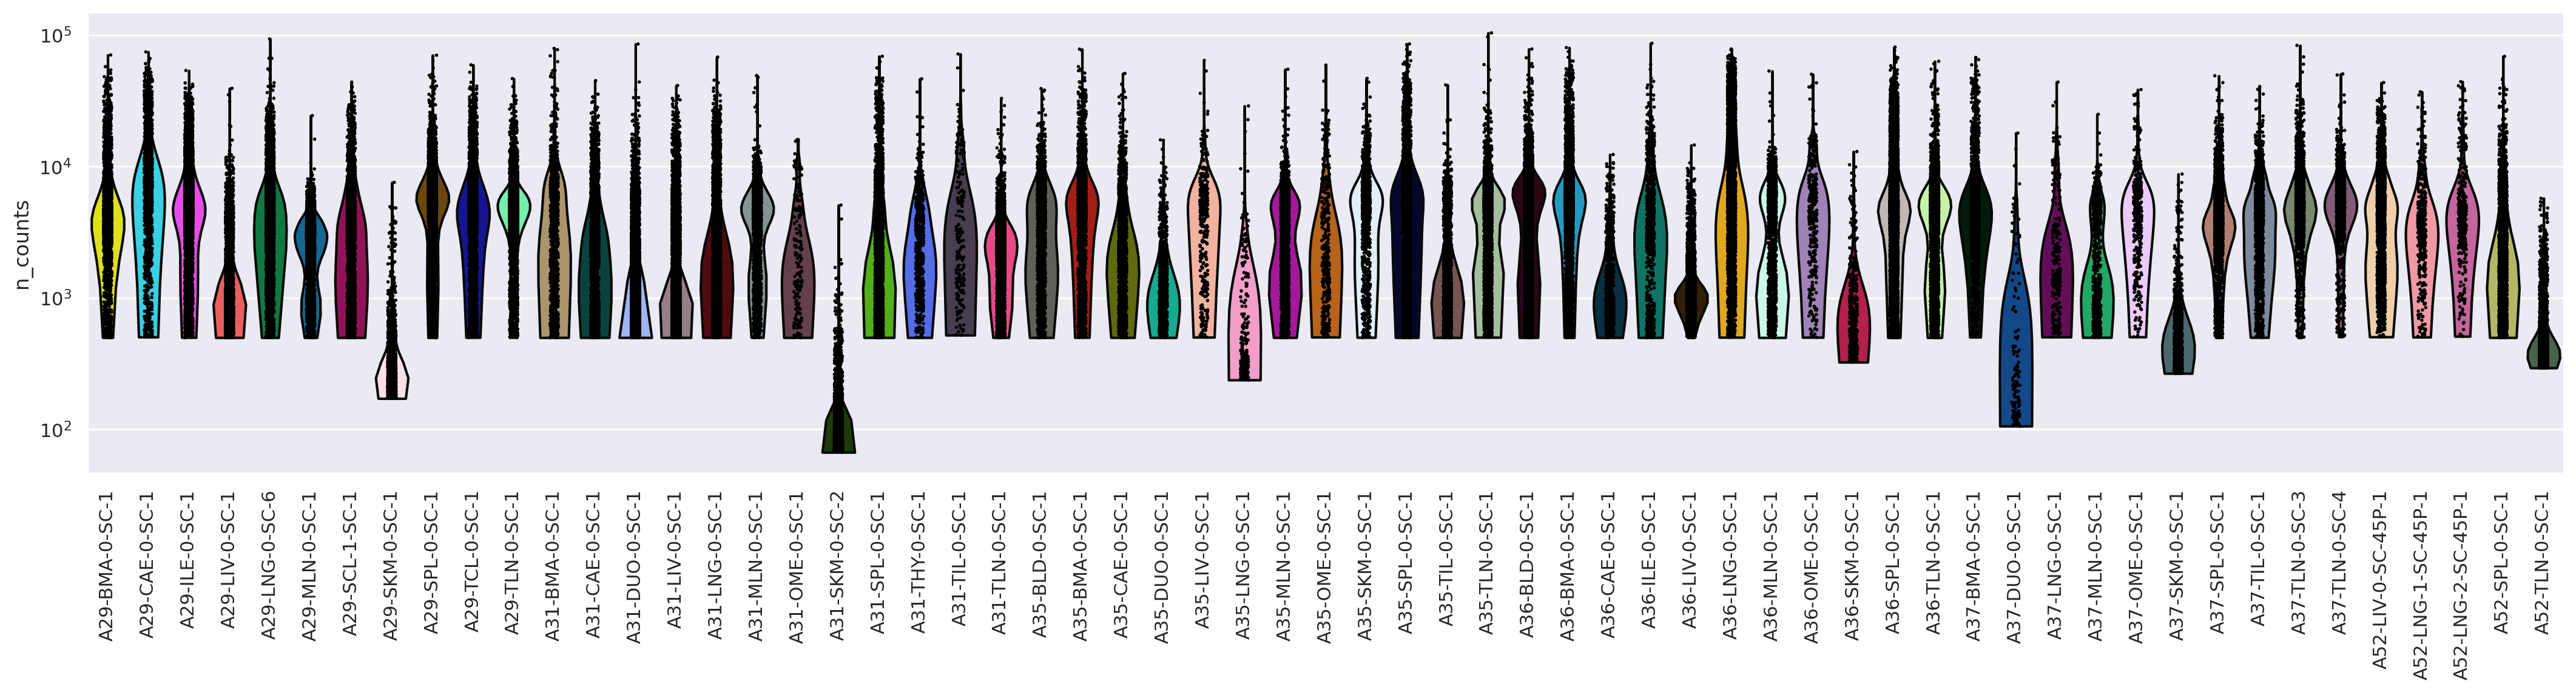

In [16]:
##### import seaborn as sns

sns.set(rc={'figure.figsize':(20,5)})
t1 = sc.pl.violin(adata, 'n_counts', groupby='sample ID', size=2, log=True, rotation=90)

/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


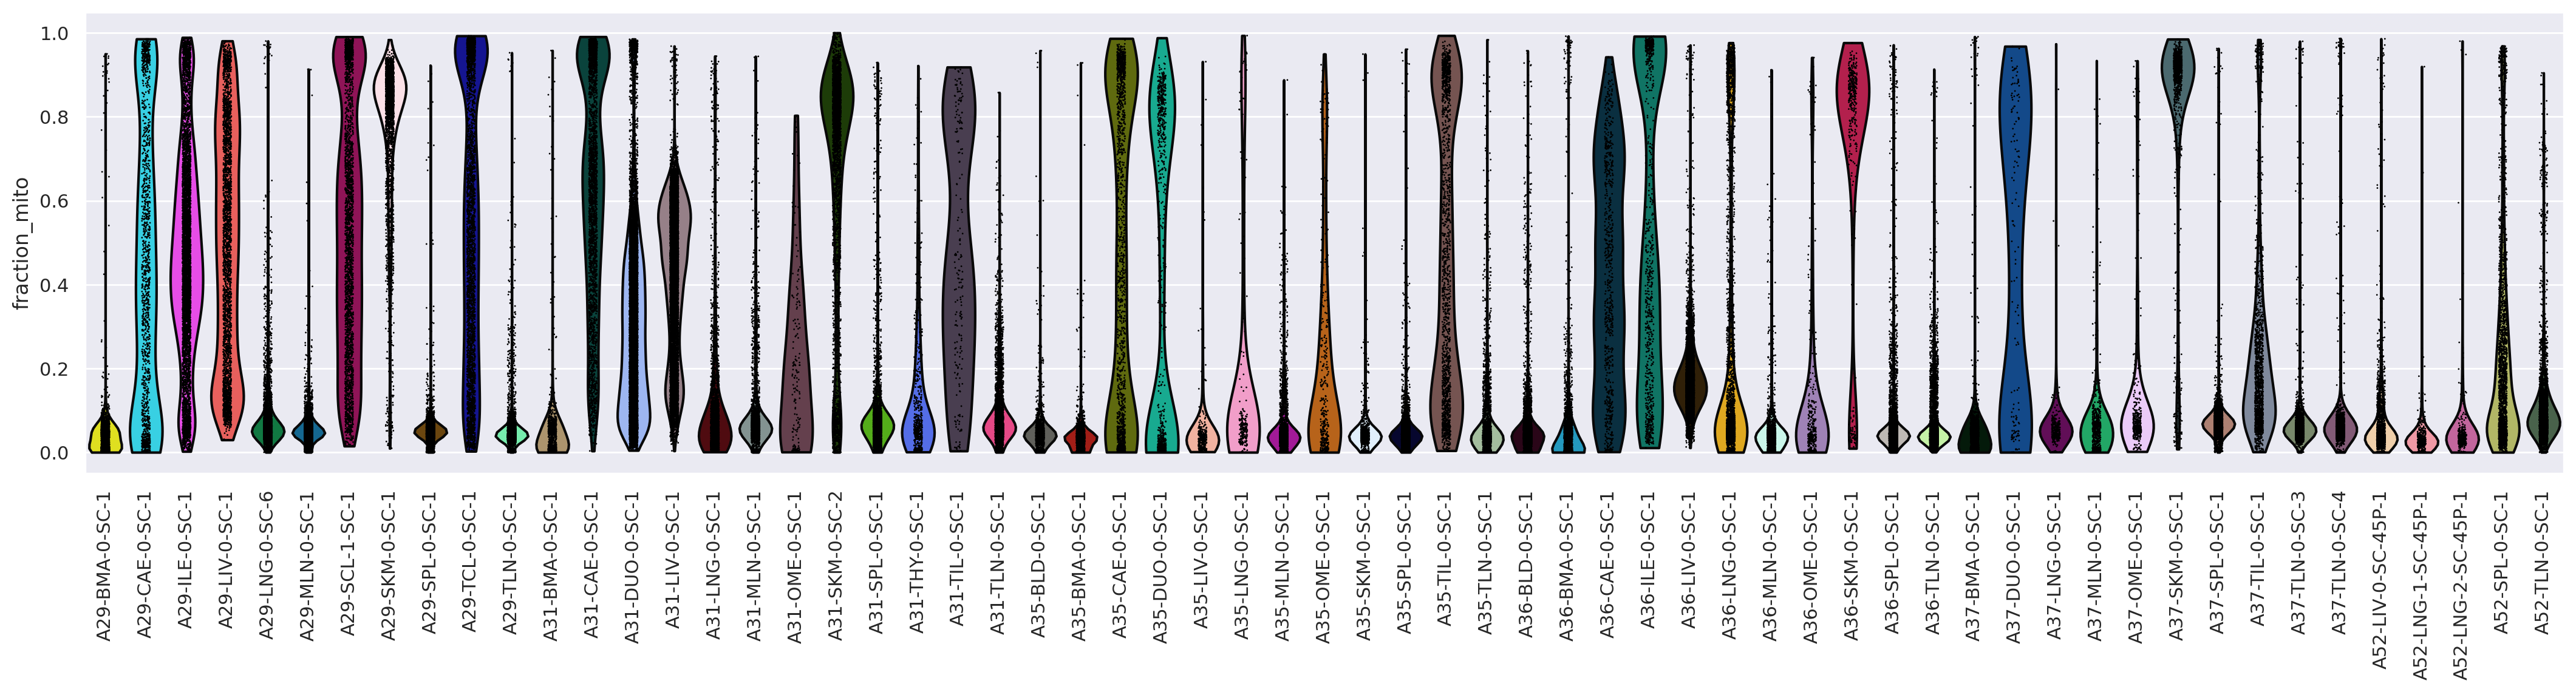

In [17]:
sns.set(rc={'figure.figsize':(20,5)})
t2 = sc.pl.violin(adata, 'fraction_mito', groupby='sample ID', rotation=90)

/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


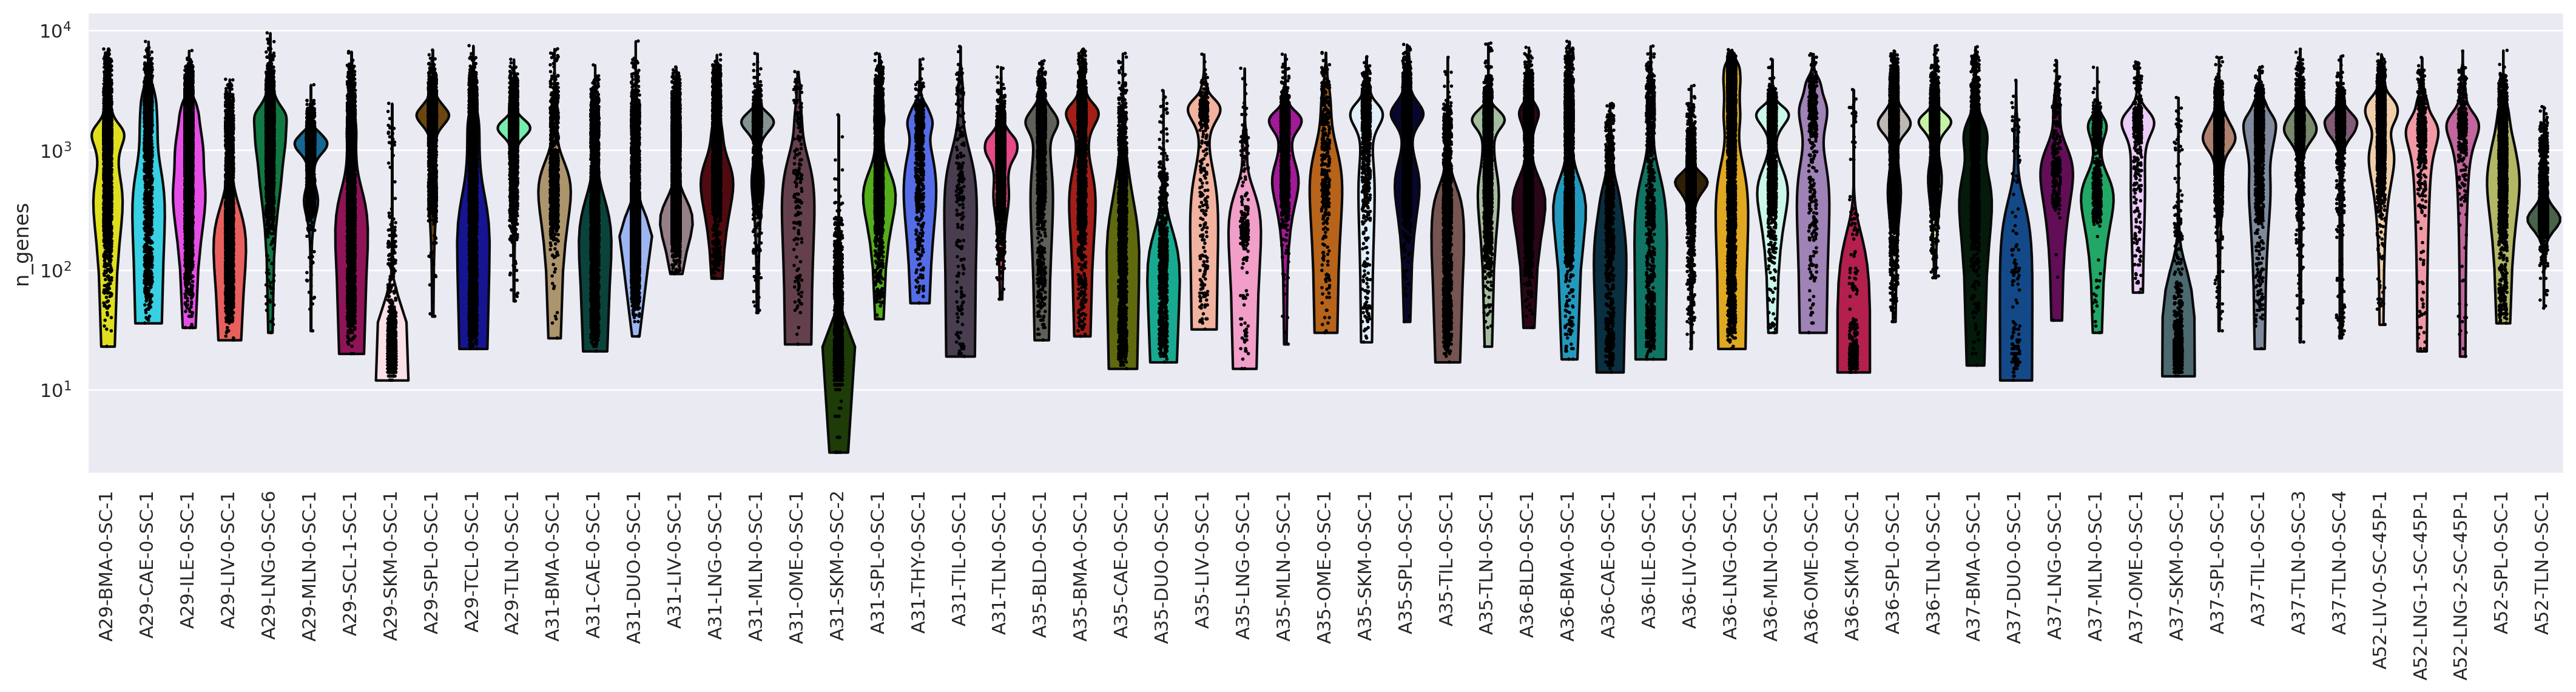

In [18]:
sns.set(rc={'figure.figsize':(20,5)})
t3 = sc.pl.violin(adata, 'n_genes', groupby='sample ID', size=2, log=True, rotation=90)

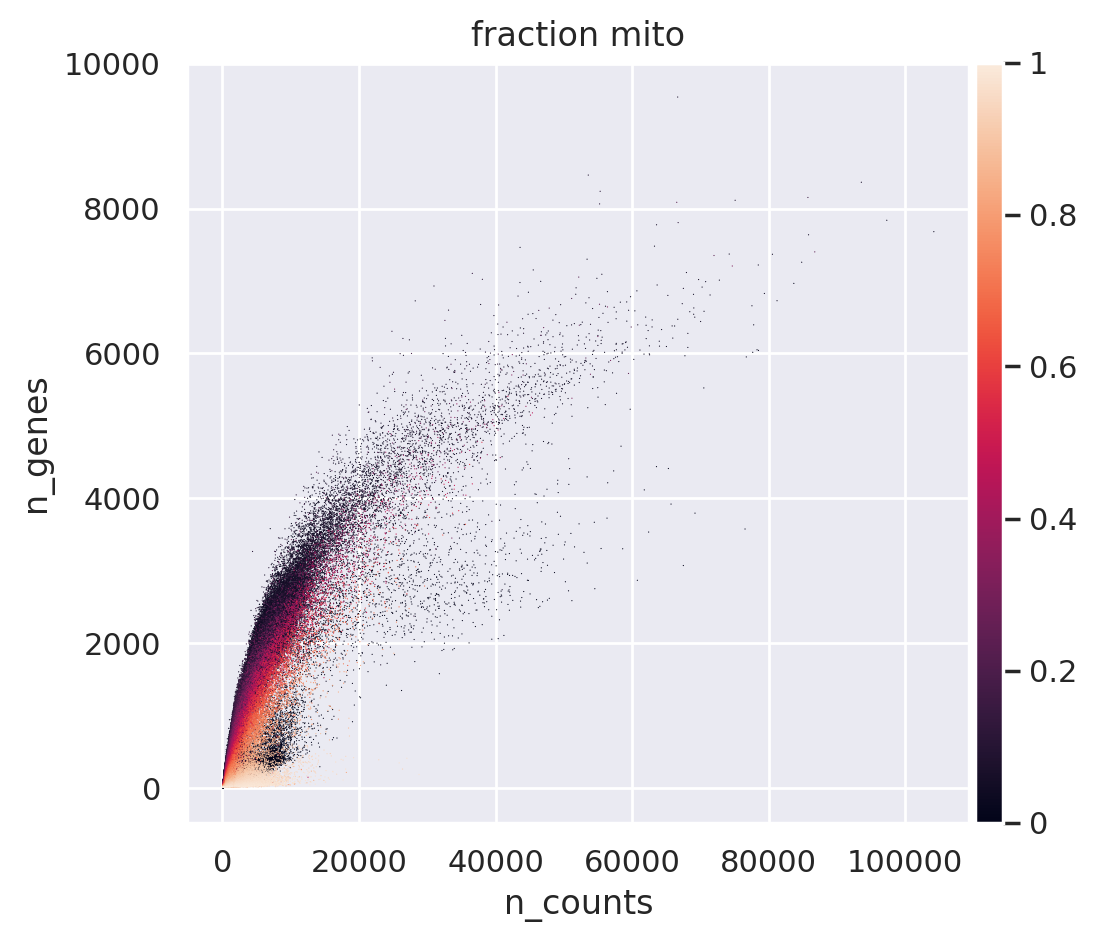

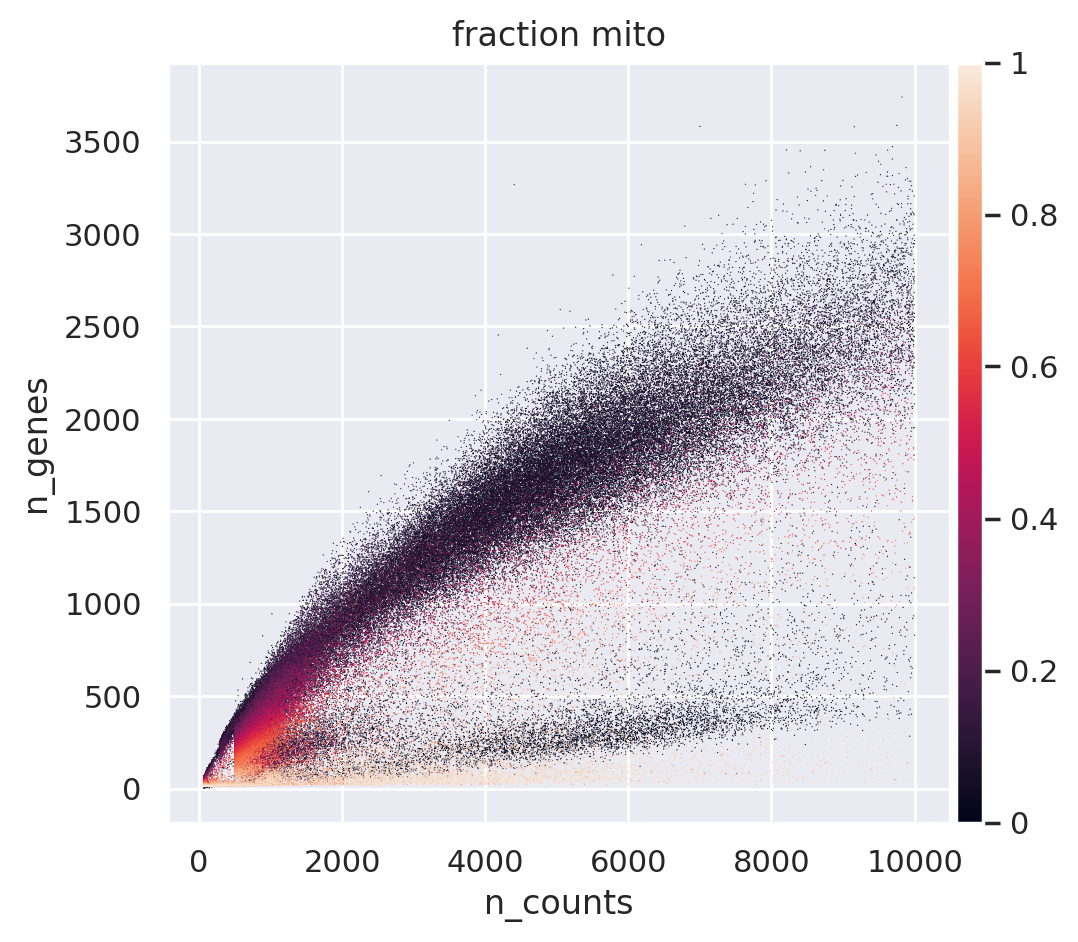

In [19]:
#Data quality summary plots
sns.set(rc={'figure.figsize':(5,5)})
p1 = sc.pl.scatter(adata, 'n_counts', 'n_genes', color='fraction_mito')
p2 = sc.pl.scatter(adata[adata.obs['n_counts']<10000], 'n_counts', 'n_genes', color='fraction_mito')

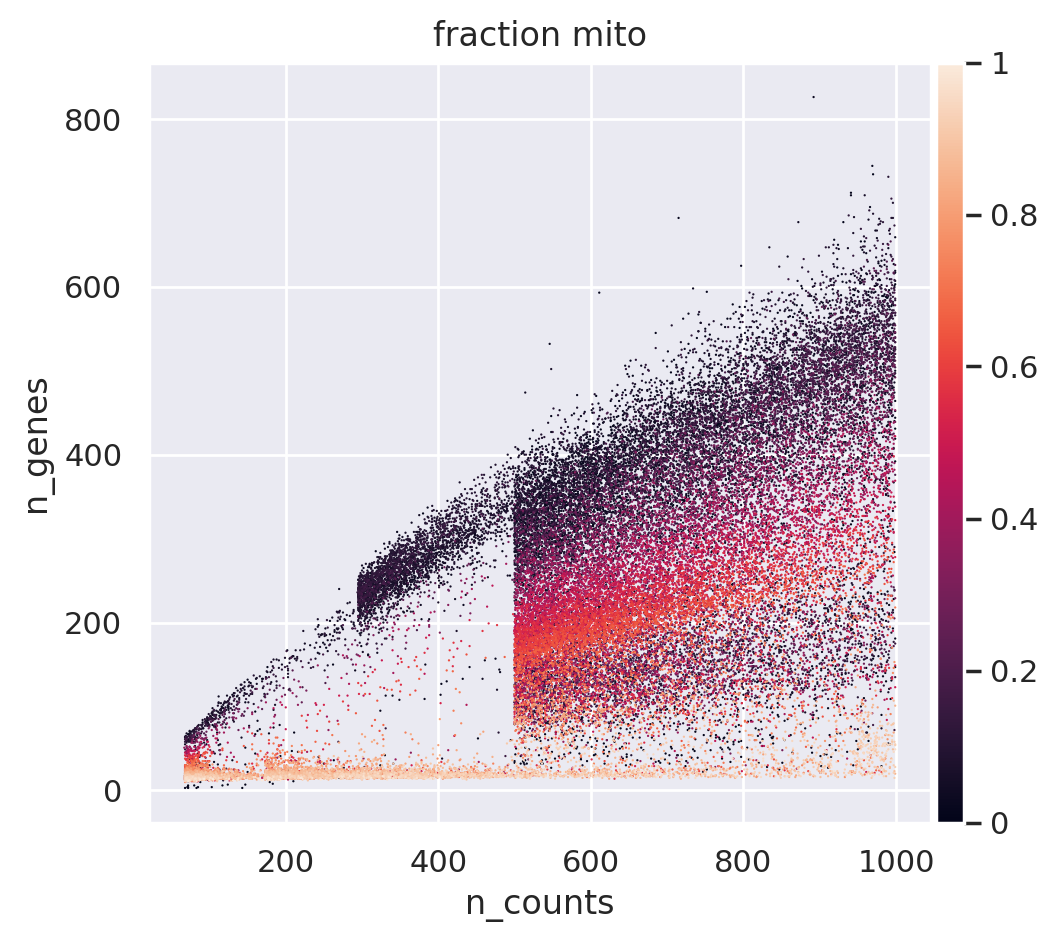

In [20]:
#Data quality summary plots
sns.set(rc={'figure.figsize':(5,5)})
p2 = sc.pl.scatter(adata[adata.obs['n_counts']<1000], 'n_counts', 'n_genes', color='fraction_mito')

The empty space at low n_counts and low n_genes is due to the filtering performed by cellranger.

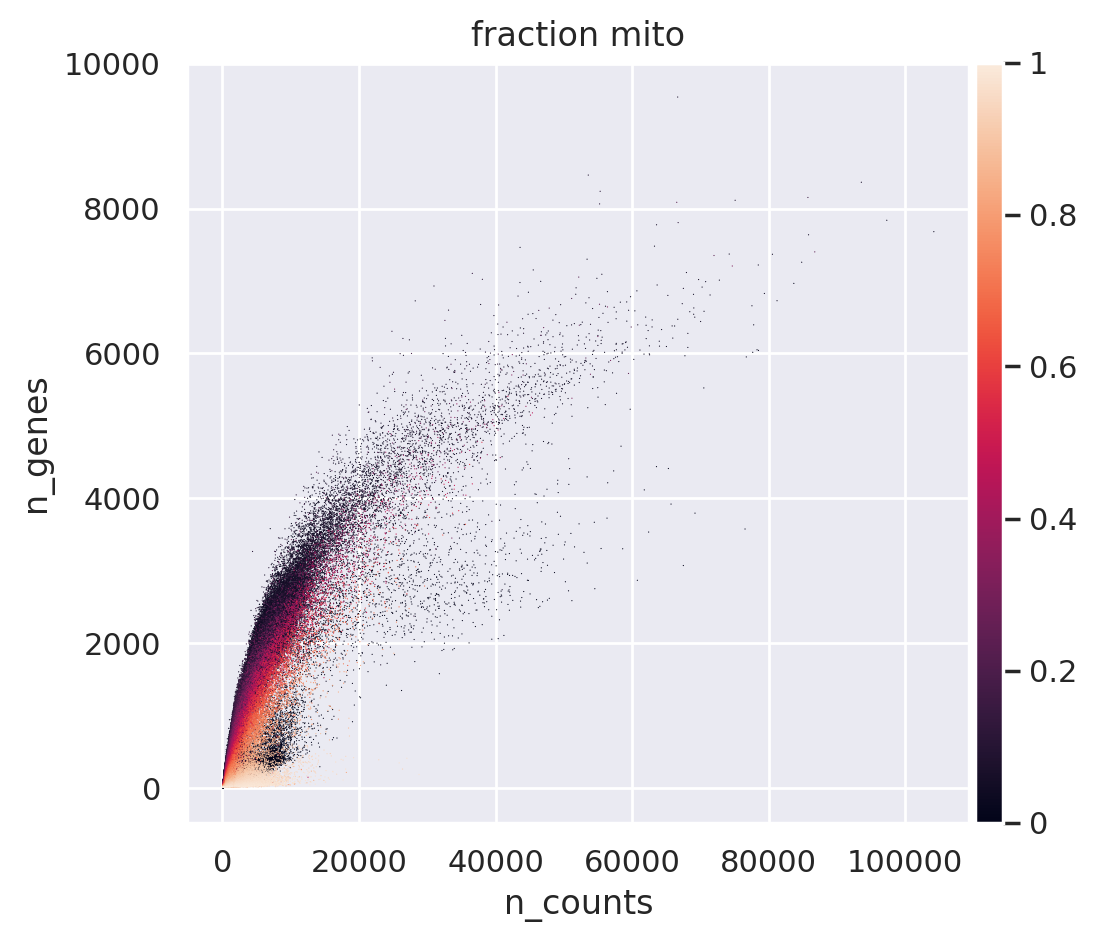

In [21]:
#Data quality summary plots
sns.set_style(
        {'font.family': 'sans-serif',
        'font.sans-serif': ['Arial']})
sns.set(rc={'figure.figsize':(5,5)})
p1 = sc.pl.scatter(adata, 'n_counts', 'n_genes', color='fraction_mito')

/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


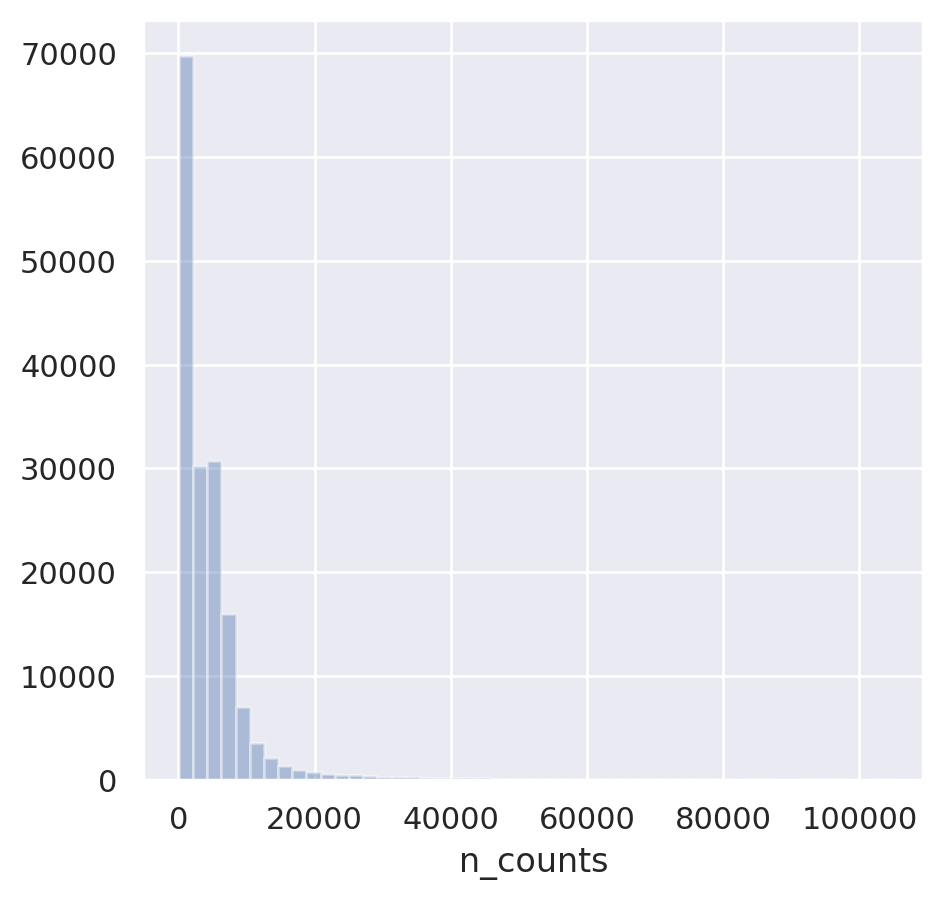

/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


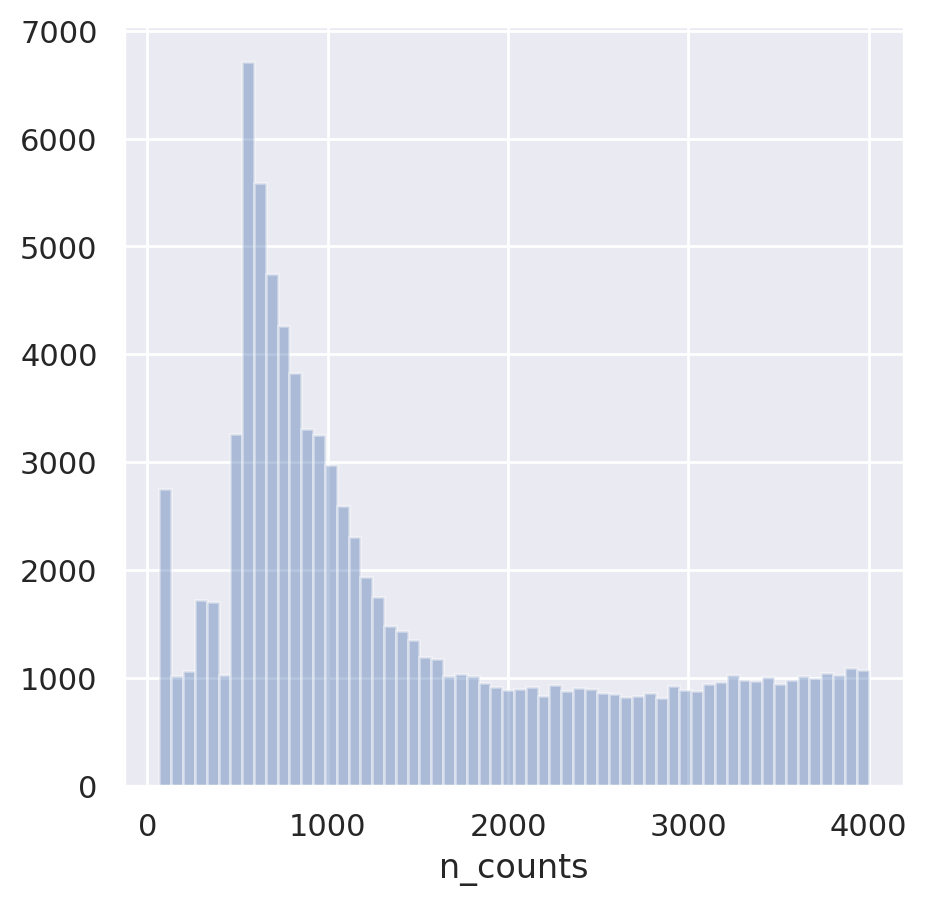

/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


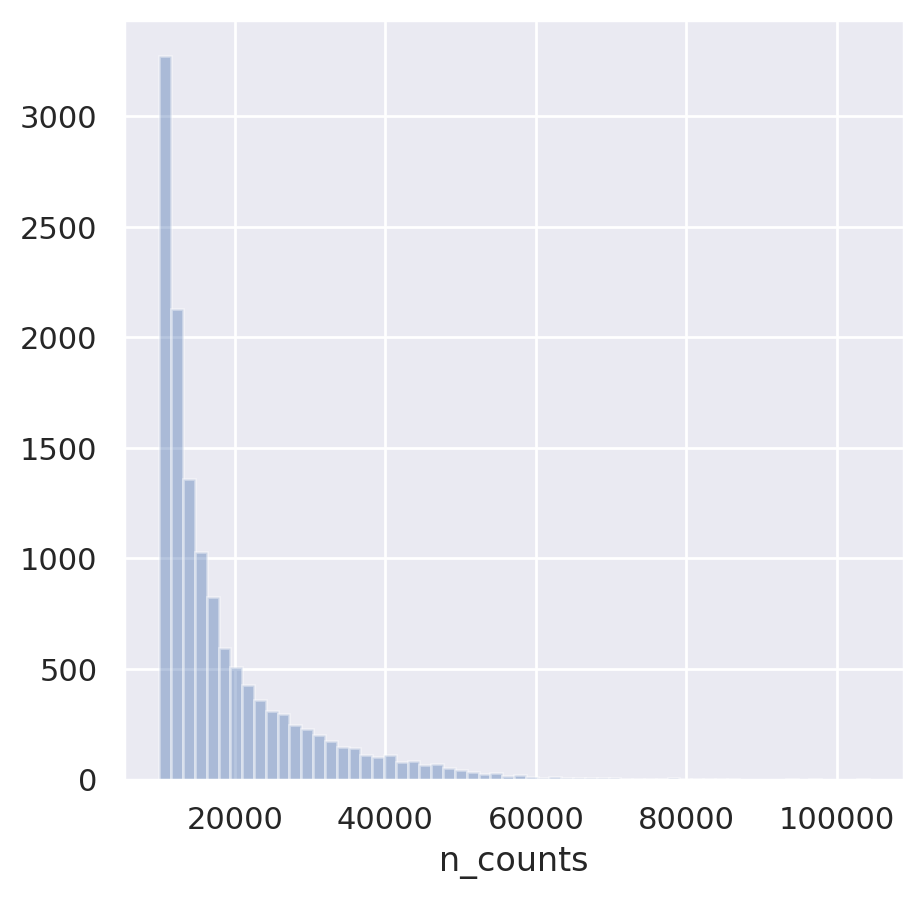

In [22]:
#Thresholding decision: counts
sns.set(rc={'figure.figsize':(5,5)})
p3 = sns.distplot(adata.obs['n_counts'], kde=False)
plt.show()

p4 = sns.distplot(adata.obs['n_counts'][adata.obs['n_counts']<4000], kde=False, bins=60)
plt.show()

p5 = sns.distplot(adata.obs['n_counts'][adata.obs['n_counts']>10000], kde=False, bins=60)
plt.show()

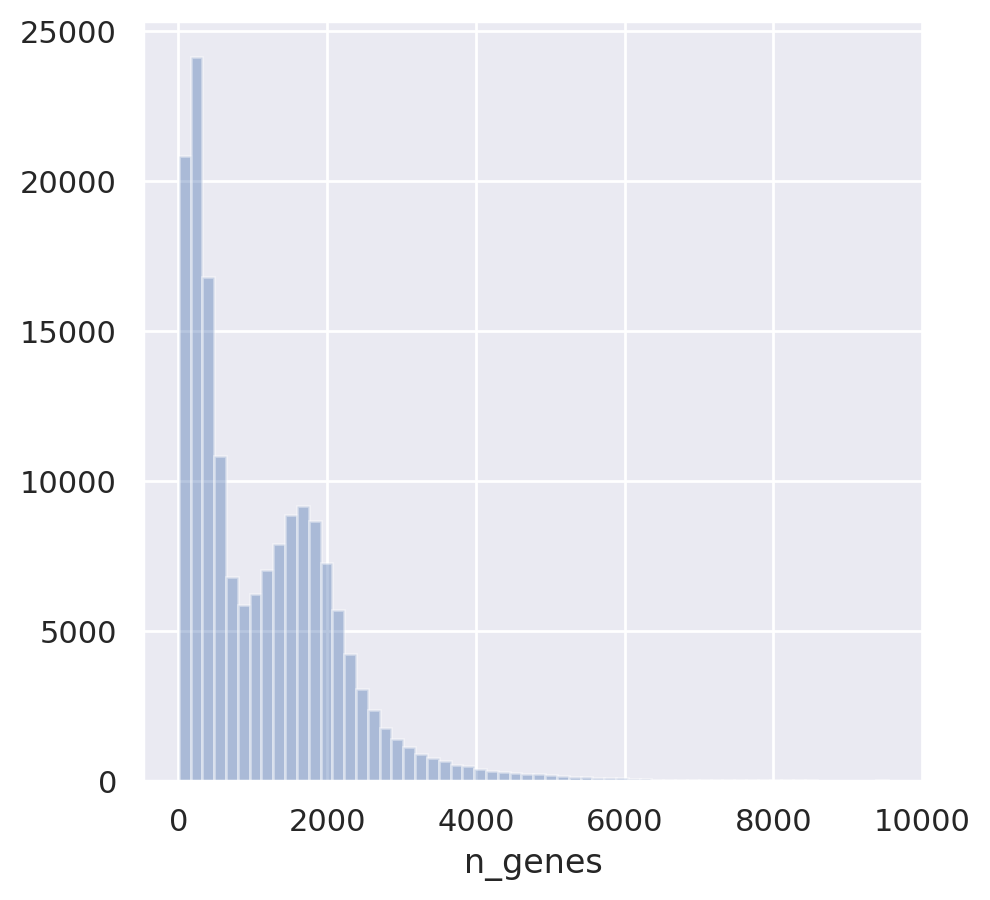

/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


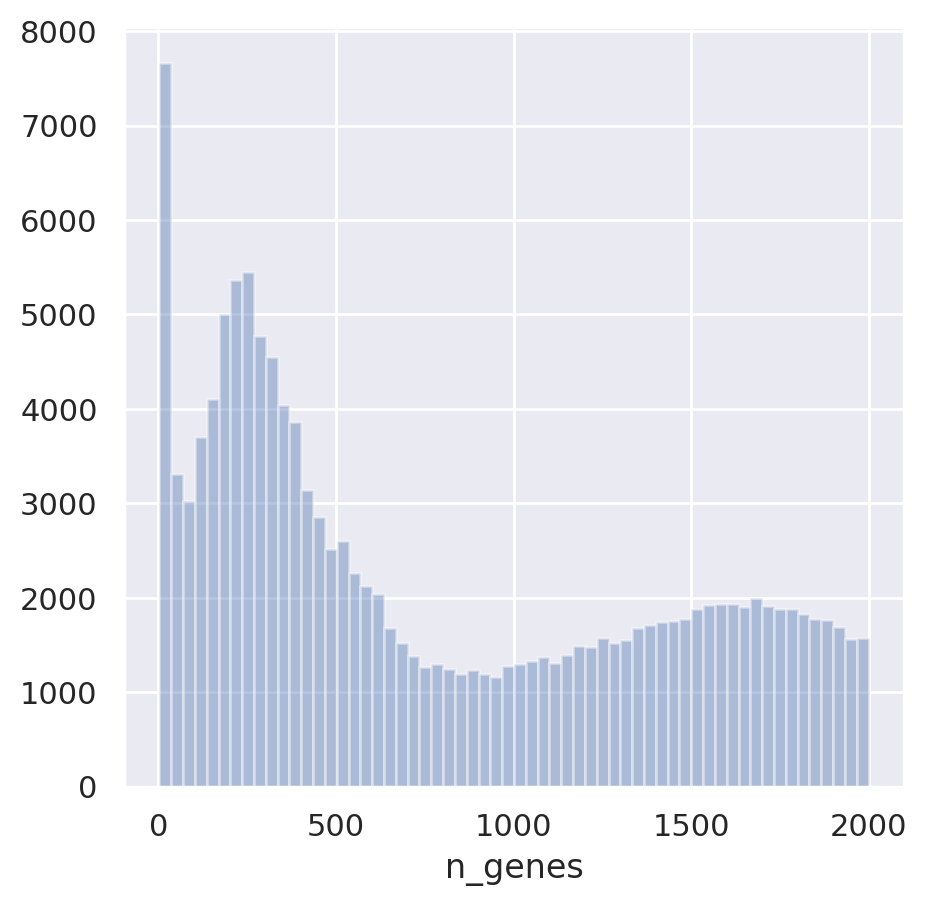

In [23]:
#Thresholding decision: genes
sns.set(rc={'figure.figsize':(5,5)})
p6 = sns.distplot(adata.obs['n_genes'], kde=False, bins=60)
plt.show()

p7 = sns.distplot(adata.obs['n_genes'][adata.obs['n_genes']<2000], kde=False, bins=60)
plt.show()


## Filtering droplets by number of genes (min_genes=600), number of umi counts (min_counts=1000) and doublet score

In [24]:
adata

AnnData object with n_obs × n_vars = 165729 × 36601
    obs: 'sample', 'Source ID', 'sex', 'patient no', 'organ code', 'sample ID', 'fraction_mito', 'n_genes', 'n_counts', 'log_counts', 'batch'
    var: 'gene_ids', 'feature_types'
    uns: 'sample ID_colors'

In [25]:
sc.pp.filter_cells(adata, min_genes=600)

filtered out 70228 cells that have less than 600 genes expressed


In [26]:
sc.pp.filter_cells(adata, min_counts=1000)

filtered out 1053 cells that have less than 1000 counts


In [27]:
adata

AnnData object with n_obs × n_vars = 94448 × 36601
    obs: 'sample', 'Source ID', 'sex', 'patient no', 'organ code', 'sample ID', 'fraction_mito', 'n_genes', 'n_counts', 'log_counts', 'batch'
    var: 'gene_ids', 'feature_types'
    uns: 'sample ID_colors'

In [28]:
adata.raw = adata

In [71]:
adata.write('/mnt/Science_revision/write/20211111_PIP_donors.h5ad')